In [1]:
%matplotlib inline
import re
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import pickle
import time
from sklearn import cluster, metrics
from sklearn import manifold, decomposition
from os import listdir
import cv2
import logging

In [2]:
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', None)

# Préparation initiale dataset

In [3]:
#from google.colab import drive
#drive.mount('/content/gdrive/') 
#flip = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Projet 06/Flipkart/flipkart_com-ecommerce_sample_1050.csv')
flip = pd.read_csv('Flipkart/flipkart_com-ecommerce_sample_1050.csv')
#
path = 'Flipkart/Images/'
list_photos = [file for file in listdir(path)]
print(len(list_photos))
#flip = pd.read_csv('Flipkart/flipkart_com-ecommerce_sample_1050.csv')

1052


In [4]:
# Récupération du premier label dans "product_category_tree"
flip['label_name'] = flip['product_category_tree'].apply(lambda x: x.split(">>")[0])
flip['label_name'] = flip['label_name'].apply(lambda x: re.sub('\W',' ',x))
flip['label_name'] = flip['label_name'].apply(lambda x: " ".join(x.split()))

In [5]:
from sklearn import preprocessing
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
  
# Encodage des labels de la colonne 'label_name'.
flip['label']= label_encoder.fit_transform(flip['label_name'])
l_cat = sorted(set(flip['label_name']))
y_cat_num = list(flip['label'])
#y_cat_num2 = list(flip['label'].unique())

In [6]:
df = flip[['uniq_id', 'label_name', 'label']]
df['uniq_id'] = df['uniq_id'].apply(lambda x : x + '.jpg')

In [7]:
df.groupby("label").count()

,uniq_id,label_name
label,,
0,150,150
1,150,150
2,150,150
3,150,150
4,150,150
5,150,150
6,150,150


# Fonctions communes

In [105]:
# Calcul PCA, Tsne, détermination des clusters et calcul ARI entre vraies catégories et n° de clusters
from sklearn.decomposition import PCA


def PCA_fct(features, variance):
    if type(features) != np.ndarray:
        features = features.toarray()
    #df = pd.DataFrame(data=features, columns = cvect.get_feature_names_out())
    #We keep 99% of the variance and calculate principal components
    print(f"Dataset dimensions before PCA reduction: {features.shape}")
    pca = PCA(n_components = variance)
    pca.fit(features)
    features_reduced = pca.transform(features)
    
    print(f"Dataset dimensions after PCA reduction: {features_reduced.shape}")
    return features_reduced

def ARI_fct(features) :
    time1 = time.time()
    num_labels=len(l_cat)
    tsne = manifold.TSNE(n_components=2, perplexity=35, n_iter=2000, 
                                 init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)
    
    # Détermination des clusters à partir des données après Tsne 
    cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_),2)
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "time (s): ", time2)
    df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
    df_tsne["label_name"] = flip['label_name']
    df_tsne["label"] = flip['label']
    df_tsne['cluster'] = cls.labels_
    return ARI, X_tsne, df_tsne, cls.labels_


# visualisation du Tsne selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI) :
    fig = plt.figure(figsize=(15,6))
    
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=l_cat, loc="best", title="Categorie")
    plt.title('Représentation des produits par catégories réelles')
    plt.xlabel('tsne1')
    plt.ylabel('tsne2')
    
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
    plt.title('Représentation des produits par clusters')
    plt.xlabel('tsne1')
    plt.ylabel('tsne2')
    
    plt.show()
    print("ARI : ", ARI)

# **Classification automatique d’images via SIFT**

## Détermination et affichage des descripteurs SIFT pour une image

In [ ]:
sift = cv2.SIFT_create()
image = cv2.imread(path+df.uniq_id[2],0) # Using 0 to read image in grayscale mode
image = cv2.equalizeHist(image)   # equalize image histogram
kp, des = sift.detectAndCompute(image, None)
img=cv2.drawKeypoints(image,kp,image)
plt.imshow(img)
plt.show()
print("Descripteurs : ", des.shape)
print()
print(des)

## Pré-traitement des images via SIFT
### Créations des descripteurs de chaque image
- Pour chaque image passage en gris et equalisation
- création d'une liste de descripteurs par image ("sift_keypoints_by_img") qui sera utilisée pour réaliser les histogrammes par image
- création d'une liste de descripteurs pour l'ensemble des images ("sift_keypoints_all") qui sera utilisé pour créer les clusters de descripteurs

In [ ]:
# identification of key points and associated descriptors
import time, cv2
sift_keypoints = []
start = time.time()
sift  = cv2.SIFT_create(1000)

for num in range(len(df)) :
    image = cv2.imread(path+df.uniq_id[num],0) # convert in gray
    res = cv2.equalizeHist(image) # equalize image histogram
    kp, des = sift.detectAndCompute(res, None)
    sift_keypoints.append(des)
    
sift_keypoints_by_img = np.asarray(sift_keypoints, dtype=object)
sift_keypoints_all    = np.concatenate(sift_keypoints_by_img, axis=0)

print('\n')
print("Nombre de descripteurs : ", sift_keypoints_all.shape)

end = time.time() - start
print("temps de traitement SIFT descriptor : ", "%15.2f" % end, "secondes")

## Création des clusters de descripteurs
* Utilisation de MiniBatchKMeans pour obtenir des temps de traitement raisonnables

In [ ]:
from sklearn import cluster, metrics

# Determination number of clusters
start=time.time()

k = int(round(np.sqrt(len(sift_keypoints_all)),0))
print("Nombre de clusters estimés : ", k)
print("Création de",k, "clusters de descripteurs ...")

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=42) #init_size=3*k
kmeans.fit(sift_keypoints_all)

end = time.time()-start
print("temps de traitement kmeans : ", "%.2f" % end, "secondes")

## Création des features des images

- Pour chaque image :
    - prédiction des numéros de cluster de chaque descripteur
    - création d'un histogramme = comptage pour chaque numéro de cluster du nombre de descripteurs de l'image
(Features d'une image = Histogramme d'une image = Comptage pour une image du nombre de descripteurs par cluster)

In [ ]:
# Creation of histograms (features)
start = time.time()

def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist


# Creation of a matrix of histograms
hist_vectors=[]

for i, image_desc in enumerate(sift_keypoints_by_img) :
    #if i%100 == 0 : print(i)  
    hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
    hist_vectors.append(hist) #histogram is the feature vector

im_features = np.asarray(hist_vectors)

end = time.time() - start
print("temps de création histogrammes : ", "%.2f" % end, "secondes")

In [ ]:
len(hist_vectors)

## Réductions de dimension
### Réduction de dimension PCA

- La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (99%)
- L'impact est une meilleure séparation des données via le T-SNE et une réduction du temps de traitement du T-SNE



In [ ]:
print("Dimension Reduction with PCA: ")
print("-----------------")
pca_features = PCA_fct(im_features, 0.99)

### Réduction de dimension T-SNE

- Réduction de dimension en 2 composantes T-SNE pour affichage en 2D des images

In [ ]:
print("ARI and T-SNE for SIFT : ")
print("-----------------")
ARI, X_tsne, df_tsne, labels = ARI_fct(pca_features)

In [ ]:
 TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

# Classification d'image par CNN Transfer Learning

In [97]:
for index in range(len(df)):
    img = cv2.imread(path + df.uniq_id[index])
    img_resized = cv2.resize(img, (256, 256), interpolation=cv2.INTER_NEAREST)
    # Save the image in Output Folder
    cv2.imwrite('Flipkart/Images/resized_256/' + df.uniq_id[index], img_resized)

print("Images resized et saved successfully !")

Images resized et saved successfully !


In [101]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_datasets as tfds
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
import tensorflow as tf
from keras.models import Model

In [108]:
# load model
resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(256, 256, 3), pooling='max')
# summarize the model
resnet.summary()
#model.layers.pop()
output = resnet.layers[-1].output
#output = Flatten()(output)
resnet = Model(resnet.input, output)

images_gen = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_dataframe(df,
                                                                                             directory='Flipkart/Images/resized_256/', 
                                                                                             x_col='uniq_id',y_col='label_name', shuffle=False, target_size=(256, 256))
features = resnet.predict(images_gen)

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_29 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_29[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

### Réduction de dimension PCA

In [109]:
print("Dimension Reduction with PCA: ")
print("-----------------")
pca_features = PCA_fct(features, 0.99999)

Dimension Reduction with PCA: 
-----------------
Dataset dimensions before PCA reduction: (1050, 2048)
Dataset dimensions after PCA reduction: (1050, 1033)


### Réduction de dimension T-SNE

In [110]:
print("ARI and T-SNE for CNN : ")
print("-----------------")
ARI, X_tsne, df_tsne, labels = ARI_fct(pca_features)

ARI and T-SNE for CNN : 
-----------------
ARI :  0.53 time (s):  8.0


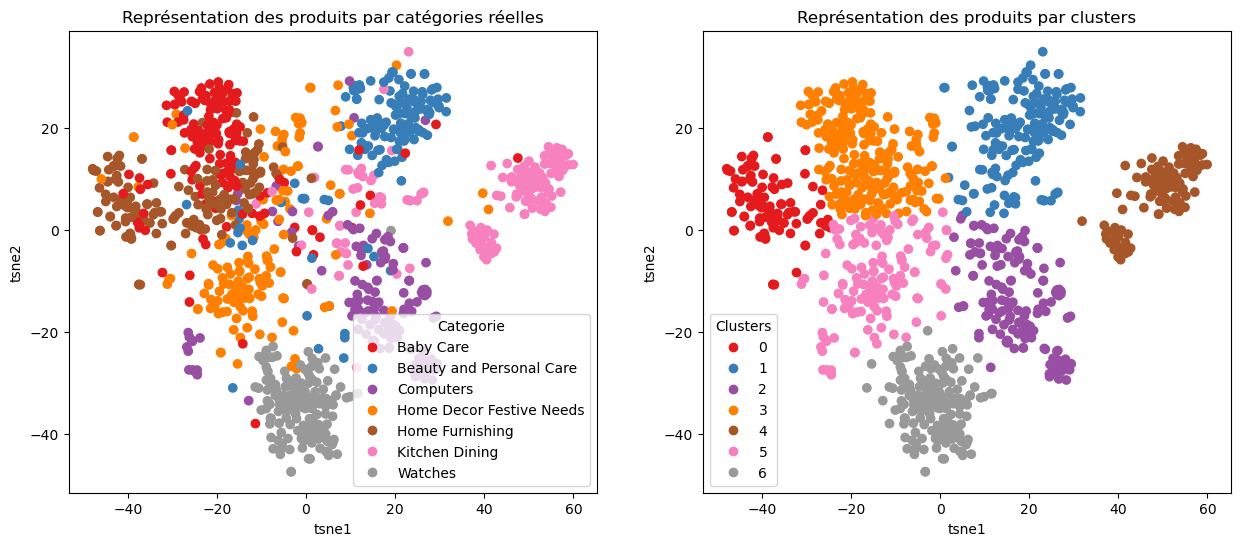

ARI :  0.53


In [111]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)